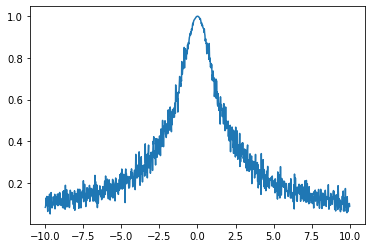

In [2]:
from math import log, log2
from scipy.stats import norm, bernoulli
import numpy as np
import matplotlib.pyplot as plt

def h(p):
    # Set h = 0 in the limit p -> 0, and p -> 1
    entropy = np.empty(p.shape)
    one_lim = np.isclose(p, 1.0)
    zero_lim = np.isclose(p, 0.0)
    limit_inds = np.logical_or(one_lim, zero_lim)
    entropy[limit_inds] = 0
    # For the rest, compute it the usual way.
    ok_inds = np.logical_not(limit_inds)
    ok_p = p[ok_inds]
    entropy[ok_inds] = -ok_p*np.log2(ok_p) - (1-ok_p)*np.log2(1-ok_p)
    return entropy

def p(z, alpha=0.9):
    return (2*alpha - 1)*norm.cdf(z) + 1-alpha

def mc_approx(x, alpha, num_terms=100):
    theta_samples = norm.rvs(size=num_terms)
    z = x * theta_samples
    probit_val = norm.cdf(z)
    #print(probit_val.max())
    entropies = h(p(z, alpha))
    return entropies.mean()

alpha = 1.0
xs = np.linspace(-10, 10, 1000)
mc_mis = [mc_approx(x, alpha) for x in xs]
plt.plot(xs, mc_mis)

## Taylor approximation of $ln(h((2\alpha_i - 1)\Phi(\theta x_i) + 1 - \alpha_i))$

In [ ]:
plt.rcParams['figure.figsize'] = (12,5)
def analytical(x, theta, alpha):
    return h(p(x*theta, alpha))

def taylor_approx(x, theta, alpha):
    """Taylor approximation of ln(h(p(theta, x)))"""
    return np.exp(- (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2)

thetas = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
x = 1
alpha = 0.7
ax.plot(thetas, analytical(thetas, x, alpha), label="Exact")
ax.plot(thetas, taylor_approx(thetas, x, alpha), '--', label="Taylor")
ax.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax.set_xlabel("t")
ax.set_ylabel("h")
ax.legend();

## Taylor approximation of difference $ln(h((2\alpha_i - 1)\Phi(\theta x_i) + 1 - \alpha_i) - h(\alpha_i))$

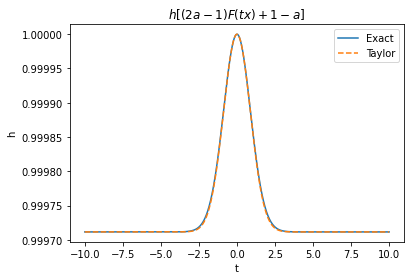

In [18]:
def analytical(x, theta, alpha):
    return h(p(x*theta, alpha))

def taylor_approx(x, theta, alpha):
    """Taylor approximation of ln(h(p(theta, x)))"""
    if np.isclose(alpha, 0.5):
        return np.ones(x.shape)
    alpha_entropy = h(np.atleast_1d(alpha)).item()
    constant_term = np.log(1 - alpha_entropy)
    factor_1 = 1 / (1 - alpha_entropy)
    factor_2 = - (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2
    return np.exp(constant_term + factor_1*factor_2) + alpha_entropy

thetas = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
x = 1.0
alpha = 0.51
ax.plot(thetas, analytical(thetas, x, alpha), label="Exact")
ax.plot(thetas, taylor_approx(thetas, x, alpha), '--', label="Taylor")
ax.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax.set_xlabel("t")
ax.set_ylabel("h")
ax.legend();

In [ ]:
a = bernoulli.rvs(p=0.5, size=10)
b = bernoulli.rvs(p=0.5, size=10)
c = np.logical_or(a,b)
for x, y, z in zip(a, b, c):
    print(x, y, z)
    
np.isclose(1.0, 1.0)

In [ ]:
def multi_analytical(theta, y_tildes, xs, alphas):
    trues = y_tildes == 1
    falses = y_tildes == 0
    true_terms = np.log(p(xs[trues] * theta, alphas[trues]))
    false_terms = np.log(1 - p(xs[falses] * theta, alphas[falses]))
    return np.exp(true_terms.sum() + false_terms.sum())

def multi_taylor_approx(theta, y_tildes, xs, alphas):
    """Taylor approximation of ln(h(p(theta, x)))"""
    trues = y_tildes == 1
    falses = y_tildes == 0
    true_terms = ( alphas[trues] - 1 )**2 * xs[trues]**2
    false_terms = (1 - p(xs[falses] * theta, alphas[falses]))
    inv_cov = 
    return np.exp(- (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2)

num_samples = 10
y_tildes = bernoulli.rvs(p=0.5, size=num_samples)
xs = norm.rvs(size=num_samples)
alphas = np.ones(xs.shape)
thetas = np.linspace(-10, 10, 1000)
entropies = np.array([multi_analytical(theta, y_tildes, xs, alphas) for theta in thetas])

fig, ax = plt.subplots()
ax.plot(thetas, entropies, label="Exact")
# ax.plot(thetas, taylor_approx(thetas, x, alpha), '--', label="Taylor")
ax.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax.set_xlabel("t")
ax.set_ylabel("h")
ax.legend();